#Going Deeper(CV) - 이미지 어디까지 우려볼까?

이번 프로젝트에서는 Data Augmentation 기법을 적용하여 Resnet50 결과를 학습해보겠습니다.

또한, 여러기법들도 적용하여 성능 차이도 같이 분석을 진행해보죠

실습 목표

- Augmentation을 모델 학습에 적용하기

- Augmentation의 적용을 통한 학습 효과 확인하기

- 최신 data augmentation 기법 구현 및 활용하기


목차

- 라이브러리 임포트

- stanford_dogs 데이터셋 다운

- 전처리 및 Augmentation을 함수로 구현

- 심화 기법 - CutMix, MixUp

- 데이터셋을 가공하는 메인 함수 제작

- 배치 사이즈대로 데이터셋 만들기

- CutMix, MixUp 이미지 시각화

- 모델 제작 및 모델 학습

- 모델 결과 시각화

- 모델 성능 비교

- 마무리

##라이브러리 임포트

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from tensorflow import keras

----

##stanford_dogs 데이터셋 다운

tfds.load를 사용하여 데이터를 다운받고 시각화하여 확인을 해본다.

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteY44ZGK/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteY44ZGK/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


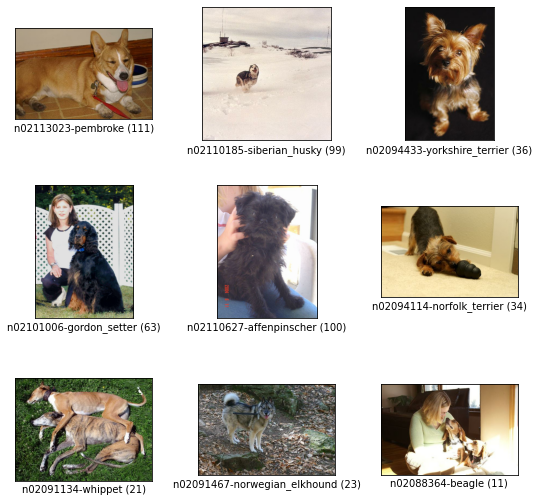

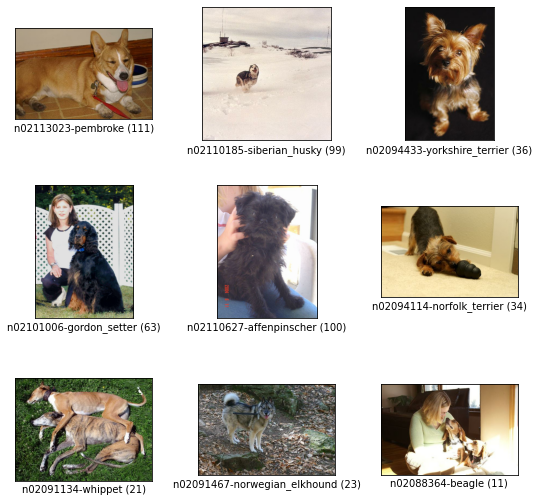

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

tfds.show_examples(ds_train, ds_info)

---

In [ ]:
num_classes = ds_info.features["label"].num_classes

---

##전처리 및 Augmentation을 함수로 구현

###전처리 함수

Augmentation을 적용하기에 앞서 기본적인 전처리 함수를 만들어 줍시다.

전처리란 이미지 사이즈를 바꿔주고 정규화를 진행시켜줍니다.

**가장 중요한 과정 입니다**.

In [ ]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

---

### Augmentation 함수

random_flip_left_right

- "flip"의 경우 좌우 대칭을 해줍니다.

random_brightness

- 다양한 환경에서 얻어진 이미지에 대응하기 위함


In [ ]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

---

##심화 기법 - CutMix, MixUp

###CutMix 사용

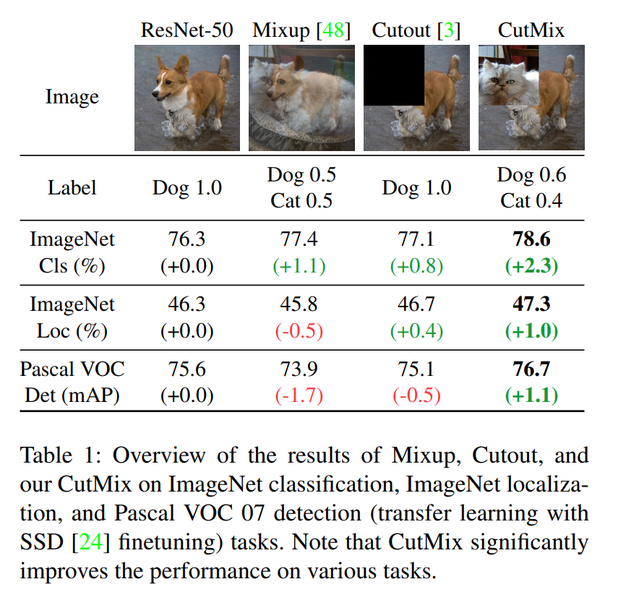

 위의 사진처럼 이미지를 잘라 붙이는게 CutMix입니다.

따라서 사진을 임의의 크기로 잘라주는 함수를 만들어줍니다.

In [ ]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

---

###이미지와 MIX

바탕이미지 image_a에서 바운딩 박스 바깥쪽 영역을, 

다른 이미지 image_b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수를 구현해 봅시다.

In [ ]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

---

###라벨과 MIX

그림에서 볼 수 있듯, 우리가 강아지와 고양이의 이미지를 섞었다면 

라벨 또한 적절한 비율로 섞여야 합니다.

In [ ]:
# mix two labels
def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

---

###CutMix 구현

두 함수 mix_2_images()와 mix_2_label()을 활용하여 배치 단위의 cutmix() 함수를 구현해 봅시다.

In [ ]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

---

###MixUp 사용

이번에는 두 이미지를 섞는 기법인 MixUp을 사용해보겠습니다.

In [ ]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b, num_classes=120):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

---

###MixUp 구현

위에서 구현한 함수를 활용하여 배치 단위의 mixup() 함수를 구현해 봅시다.

In [ ]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

---

## 데이터셋을 가공하는 메인 함수 제작

위의 정의한 함수대로 데이터를 가공해주는 메인함수를 제작

In [ ]:
def onehot(image, label, num_classes=120):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,  
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,  
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot, 
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

---

##배치 사이즈대로 데이터셋 만들기

In [ ]:
BATCH_SIZE = 16

In [ ]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_aug=True)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_cutmix=True)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True, batch_size=BATCH_SIZE)

---

## CutMix, MixUp 이미지 시각화

CutMix와 MixUp 이미지가 잘 만들어졌는지 확인해보겠습니다.

In [ ]:
# 데이터셋에서 이미지 가져와서 시각화
def draw_ds_train(ds_train, batch_size = 16, row = 6, col = 4):
    row = min(row, batch_size // col)  # row 재설정
    
    # 데이터셋에서 배치 사이즈(=16개)만큼 1번만 이미지 가져오기
    for i, (image, label) in enumerate(ds_train.take(1)):
        
        plt.figure(figsize = (8,int(8*row/col)))  # 8x8 크기
        for j in range(row * col):
            plt.subplot(row, col, j+1)
            plt.axis('off')
            plt.imshow(image[j,])  # 가져온 이미지(16개) 하나씩 출력
                    
        plt.tight_layout()
        plt.show()

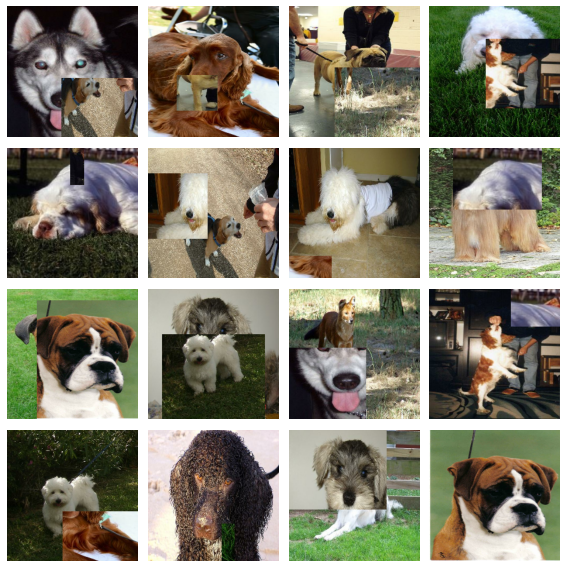

In [ ]:
draw_ds_train(ds_train_aug_cutmix, 16)

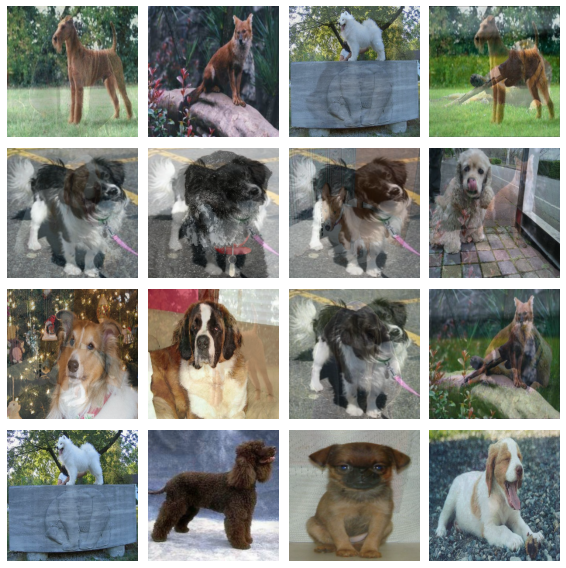

In [ ]:
draw_ds_train(ds_train_aug_mixup, 16)

---

##모델 제작 및 모델 학습

모델 제작과 학습에는 사전에 미리 훈련된 Resnet-50 모델을 사용합니다.

단, 마지막에 분류에서 차이가 있어 라벨값을 재 설정하여 

최종적으로 재 설정된 라벨에서 분류하도록 만들어줍니다.

In [ ]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
EPOCH = 20

resnet50.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001),
    metrics = ['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch = int(ds_info.splits['train'].num_examples / 16),
    validation_steps = int(ds_info.splits['test'].num_examples / 16),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True,
)

Epoch 1/20
750/750 [==============================] - 189s 217ms/step - loss: 4.4913 - accuracy: 0.0720 - val_loss: 4.5947 - val_accuracy: 0.0507
Epoch 2/20
750/750 [==============================] - 167s 223ms/step - loss: 2.9255 - accuracy: 0.3832 - val_loss: 2.1900 - val_accuracy: 0.4838
Epoch 3/20
750/750 [==============================] - 163s 217ms/step - loss: 1.9527 - accuracy: 0.5847 - val_loss: 1.6436 - val_accuracy: 0.5848
Epoch 4/20
750/750 [==============================] - 163s 217ms/step - loss: 1.4632 - accuracy: 0.6773 - val_loss: 1.4103 - val_accuracy: 0.6241
Epoch 5/20
750/750 [==============================] - 163s 217ms/step - loss: 1.1267 - accuracy: 0.7563 - val_loss: 1.2528 - val_accuracy: 0.6564
Epoch 6/20
750/750 [==============================] - 164s 218ms/step - loss: 0.9581 - accuracy: 0.7876 - val_loss: 1.1459 - val_accuracy: 0.6756
Epoch 7/20
750/750 [==============================] - 164s 218ms/step - loss: 0.7234 - accuracy: 0.8616 - val_loss: 1.0997 -

---

###Aug 적용된 모델 만들기

이번에는 이미지 Augmentation을 적용한 데이터셋으로 모델을 학습시키겠습니다.

In [ ]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224,224,3),
        pooling = 'avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

aug_resnet50.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001),
    metrics = ['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch = int(ds_info.splits['train'].num_examples / 16),
    validation_steps = int(ds_info.splits['test'].num_examples / 16),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True,
)

Epoch 1/20
750/750 [==============================] - 172s 217ms/step - loss: 4.5139 - accuracy: 0.0696 - val_loss: 4.5279 - val_accuracy: 0.0623
Epoch 2/20
750/750 [==============================] - 162s 216ms/step - loss: 3.0716 - accuracy: 0.3332 - val_loss: 2.2398 - val_accuracy: 0.4616
Epoch 3/20
750/750 [==============================] - 162s 216ms/step - loss: 2.1208 - accuracy: 0.5230 - val_loss: 1.6829 - val_accuracy: 0.5721
Epoch 4/20
750/750 [==============================] - 162s 217ms/step - loss: 1.6225 - accuracy: 0.6212 - val_loss: 1.3843 - val_accuracy: 0.6286
Epoch 5/20
750/750 [==============================] - 162s 216ms/step - loss: 1.3382 - accuracy: 0.6851 - val_loss: 1.2284 - val_accuracy: 0.6607
Epoch 6/20
750/750 [==============================] - 162s 216ms/step - loss: 1.1014 - accuracy: 0.7377 - val_loss: 1.1306 - val_accuracy: 0.6777
Epoch 7/20
750/750 [==============================] - 161s 215ms/step - loss: 0.9968 - accuracy: 0.7544 - val_loss: 1.0650 -

---

###CutMix 적용된 모델 만들기

In [ ]:
cut_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224,224,3),
        pooling = 'avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

cut_aug_resnet50.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001),
    metrics = ['accuracy'],
)

history_resnet50_aug_cut = cut_aug_resnet50.fit(
    ds_train_aug_cutmix, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch = int(ds_info.splits['train'].num_examples / 16),
    validation_steps = int(ds_info.splits['test'].num_examples / 16),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True,
)

Epoch 1/20
750/750 [==============================] - 173s 218ms/step - loss: 4.8674 - accuracy: 0.0192 - val_loss: 5.0946 - val_accuracy: 0.0199
Epoch 2/20
750/750 [==============================] - 162s 217ms/step - loss: 4.3611 - accuracy: 0.0922 - val_loss: 3.2138 - val_accuracy: 0.2731
Epoch 3/20
750/750 [==============================] - 163s 217ms/step - loss: 3.9151 - accuracy: 0.1979 - val_loss: 2.4256 - val_accuracy: 0.4255
Epoch 4/20
750/750 [==============================] - 163s 217ms/step - loss: 3.5972 - accuracy: 0.2928 - val_loss: 1.9844 - val_accuracy: 0.5119
Epoch 5/20
750/750 [==============================] - 163s 217ms/step - loss: 3.3784 - accuracy: 0.3438 - val_loss: 1.6672 - val_accuracy: 0.5666
Epoch 6/20
750/750 [==============================] - 163s 217ms/step - loss: 3.2052 - accuracy: 0.3911 - val_loss: 1.5062 - val_accuracy: 0.6048
Epoch 7/20
750/750 [==============================] - 163s 217ms/step - loss: 3.1025 - accuracy: 0.4196 - val_loss: 1.3845 -

---

###MixUp 적용된 모델 만들기

In [ ]:
mix_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224,224,3),
        pooling = 'avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

mix_aug_resnet50.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001),
    metrics = ['accuracy'],
)

history_resnet50_aug_mix = mix_aug_resnet50.fit(
    ds_train_aug_mixup, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch = int(ds_info.splits['train'].num_examples / 16),
    validation_steps = int(ds_info.splits['test'].num_examples / 16),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True,
)

Epoch 1/20
750/750 [==============================] - 172s 218ms/step - loss: 4.8100 - accuracy: 0.0288 - val_loss: 5.0918 - val_accuracy: 0.0216
Epoch 2/20
750/750 [==============================] - 162s 216ms/step - loss: 4.2087 - accuracy: 0.1400 - val_loss: 2.9155 - val_accuracy: 0.3166
Epoch 3/20
750/750 [==============================] - 162s 217ms/step - loss: 3.6645 - accuracy: 0.2735 - val_loss: 2.1728 - val_accuracy: 0.4616
Epoch 4/20
750/750 [==============================] - 162s 217ms/step - loss: 3.3428 - accuracy: 0.3671 - val_loss: 1.7870 - val_accuracy: 0.5368
Epoch 5/20
750/750 [==============================] - 163s 217ms/step - loss: 3.1206 - accuracy: 0.4263 - val_loss: 1.5609 - val_accuracy: 0.5876
Epoch 6/20
750/750 [==============================] - 163s 217ms/step - loss: 2.9827 - accuracy: 0.4667 - val_loss: 1.3995 - val_accuracy: 0.6196
Epoch 7/20
750/750 [==============================] - 164s 218ms/step - loss: 2.8665 - accuracy: 0.5066 - val_loss: 1.2953 -

---

##모델 결과 시각화

학습된 결과만으로는 도드라지는 특징이 나타나지 않습니다.

시각화를 하여 확인해보겠습니다.

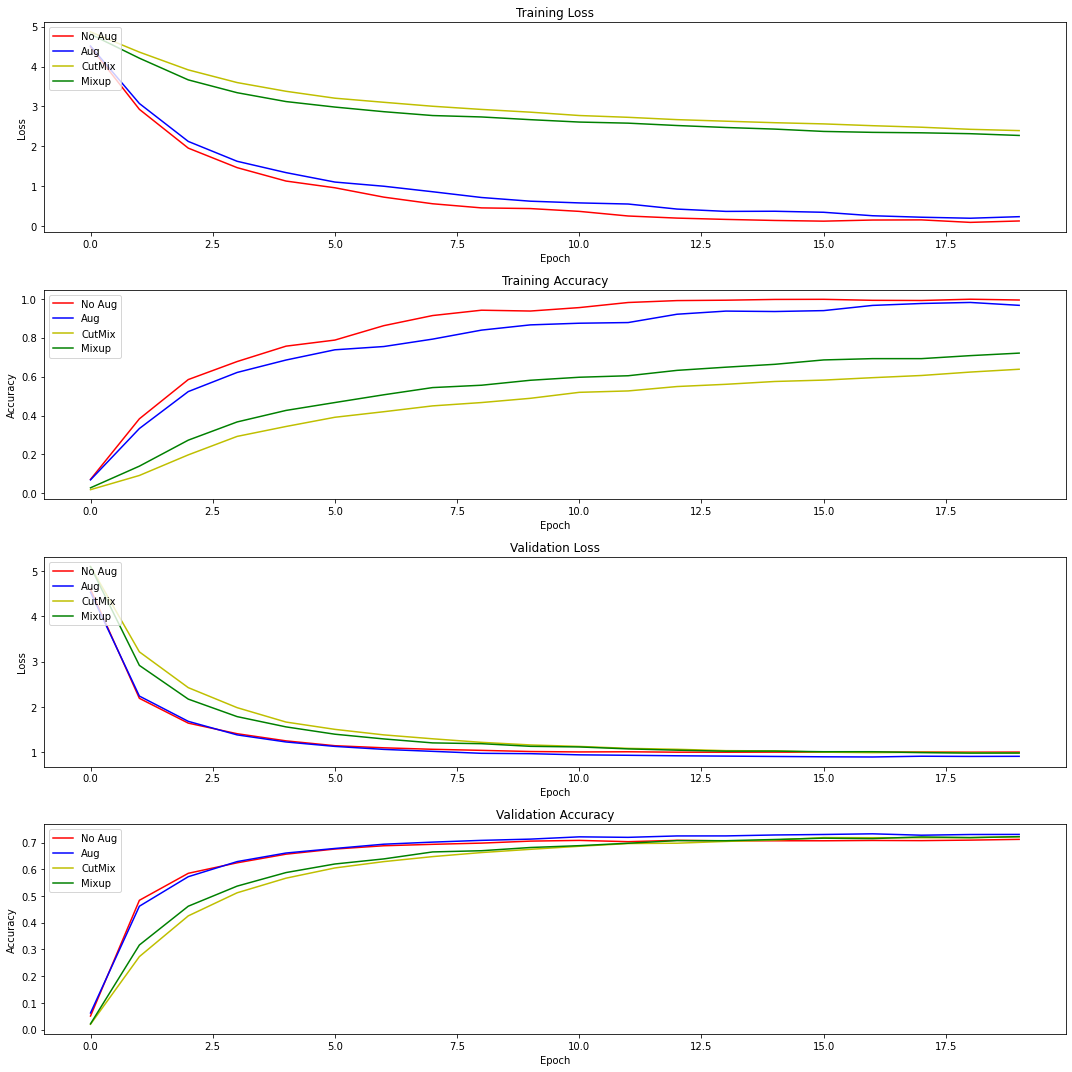

In [ ]:
plt.subplots(figsize=(15,15))

plt.subplot(4, 1, 1)
plt.plot(history_resnet50_no_aug.history['loss'], 'r')
plt.plot(history_resnet50_aug.history['loss'], 'b')
plt.plot(history_resnet50_aug_cut.history['loss'], 'y')
plt.plot(history_resnet50_aug_mix.history['loss'], 'g')
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'Aug', 'CutMix', 'Mixup'], loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(history_resnet50_no_aug.history['accuracy'], 'r')
plt.plot(history_resnet50_aug.history['accuracy'], 'b')
plt.plot(history_resnet50_aug_cut.history['accuracy'], 'y')
plt.plot(history_resnet50_aug_mix.history['accuracy'], 'g')
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'Aug', 'CutMix', 'Mixup'], loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_aug_cut.history['val_loss'], 'y')
plt.plot(history_resnet50_aug_mix.history['val_loss'], 'g')
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'Aug', 'CutMix', 'Mixup'], loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cut.history['val_accuracy'], 'y')
plt.plot(history_resnet50_aug_mix.history['val_accuracy'], 'g')
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'Aug', 'CutMix', 'Mixup'], loc='upper left')

plt.tight_layout()
plt.show()

---

###특정 범위 시각화

이번에는 특정 범위를 시각화하여 조금더 상세하게 확인해보겠습니다.

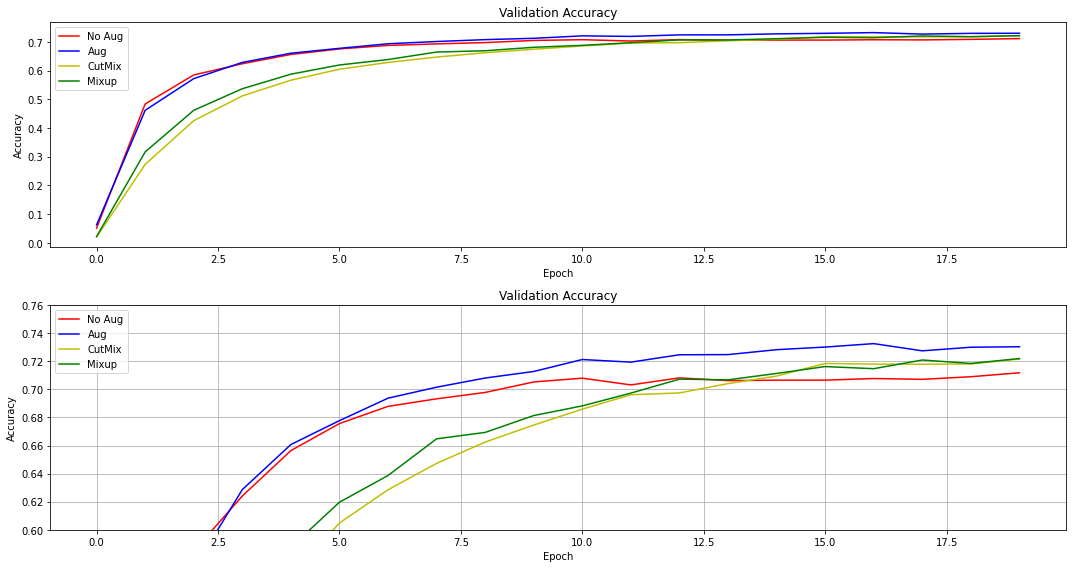

In [ ]:
plt.subplots(figsize=(15,8))

plt.subplot(2, 1, 1)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cut.history['val_accuracy'], 'y')
plt.plot(history_resnet50_aug_mix.history['val_accuracy'], 'g')
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'Aug', 'CutMix', 'Mixup'], loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cut.history['val_accuracy'], 'y')
plt.plot(history_resnet50_aug_mix.history['val_accuracy'], 'g')
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'Aug', 'CutMix', 'Mixup'], loc='upper left')
plt.grid(True)

#범위 설정
plt.ylim(0.60, 0.76) 

plt.tight_layout()
plt.show()

---

##모델 성능 비교

조금 더 자세하게 보기 위하여

val_accuracy값을 데이터 프레임에 저장하여 describe로 최대, 평균, 최소값을 확인해보겠습니다.

In [ ]:
import pandas as pd

resnet = {
        'No Aug' : history_resnet50_no_aug.history['val_accuracy'],
        'Aug' : history_resnet50_aug.history['val_accuracy'],
        'CutMix' : history_resnet50_aug_cut.history['val_accuracy'],
        'MixUp' : history_resnet50_aug_mix.history['val_accuracy']
    }
df_resnet50_val = pd.DataFrame(resnet, index=[f'EPOCHS_{i}' for i in range(EPOCH)])

In [ ]:
df_resnet50_val.head()

,No Aug,Aug,CutMix,MixUp
EPOCHS_0,0.050723,0.062267,0.019939,0.021572
EPOCHS_1,0.483792,0.461637,0.273088,0.316581
EPOCHS_2,0.584771,0.572062,0.425490,0.461637
EPOCHS_3,0.624067,0.628615,0.511894,0.536847
EPOCHS_4,0.656367,0.660681,0.566581,0.587570


In [ ]:
df_resnet50_val.describe()

,No Aug,Aug,CutMix,MixUp
count,20.000000,20.000000,20.000000,20.000000
mean,0.646659,0.657352,0.605061,0.615030
std,0.151094,0.155305,0.179782,0.173783
min,0.050723,0.062267,0.019939,0.021572
25%,0.670796,0.673449,0.595266,0.611620
50%,0.704174,0.716010,0.680212,0.684760
75%,0.707235,0.727583,0.711521,0.712133
max,0.711754,0.732509,0.721548,0.721898


---

##마무리

처음에는 **모델 학습을 lr = 0.01로 진행**해보았습니다.

하지만 **전처리가 상당히 잘 이루어진 탓인지 accuracy가 급속히 올라 값을 비교하는데 어려움**이 있을꺼 같았습니다.

따라서 **lr = 0.001로 수정하여 학습을 진행**해보았습니다.

결과는 **train과 val로 나눠서 비교**를 해야할꺼 같습니다.

no_aug 모델을 살펴보시면 Augmentation을 적용시키지 않아

즉, 있는 그대로의 데이터를 사용해서

**train값이 빠르게 90퍼 까지 도달**을 합니다.

하지만 val를 확인하게 되면 70퍼로 제대로된 분류가 이루어지지는 않습니다.

그 반면, **Augmentation, CutMix, MixUp을 적용시킨 모델을 경우는 train에서는 정확도가 쳐지지만**,

그 반대로 **val에서는 no_aug 모델보다 높은 정확도**를 보여주고 있습니다.

###결론

**저희가 분류 모델을 만드는 이유는 train과 test 데이터에 없는 완전 새로운 강아지 사진을 모델에 보여주었을때,**

**그걸 분류해낼 수 있는 모델을 만드는 것이라고 생각**합니다.

따라서 **Augmentation을 적용하지 않는다면 train, test에는 존재하지 않는 일그러지거나, 상하반전된 사진을 구분할수는 없을것**입니다.

만약 더 다양한 Augmentation을 적용했다면 지금보다 좋은 성능이 나왔을 것 입니다.